In [1]:
from matplotlib import pyplot as plt
# import multiprocessing as mp
import numpy as np
# import pandas as pd

from mypkg.redux import redux_utils as rxu, redux_vip as rxv
from mypkg.redux.redux_npy import ADI_npy, ASDI_npy, PCA_npy

from hciplot import plot_frames, plot_cubes
# from vip_hci.var import frame_center, mask_circle
from vip_hci.metrics import completeness_curve, contrast_curve, detection
# from vip_hci.metrics import inverse_stim_map, significance, snr, snrmap, stim_map, throughput
from vip_hci.fm import cube_planet_free
# from vip_hci.fm import firstguess, normalize_psf
# from vip_hci.preproc import find_scal_vector, frame_rescaling
from vip_hci.psfsub import frame_diff, median_sub, pca, pca_annular, xloci

In [2]:
lib = "vip"
algo = "ASDI"
sub_type = "ADI"

ncomp = 10
first_chnl = 45
last_chnl = 74
nframes = 2202
nskip_frames = 20
channels = list(range(first_chnl, last_chnl + 1))
frames = range(0, nframes, nskip_frames)

In [3]:
name_kwargs = {"lib": lib, "algo": algo, "sub_type": sub_type,
                "first_chnl": first_chnl, "last_chnl": last_chnl,
                "ncomp": ncomp, "nskip_frames": nskip_frames}

data_path = "./data/005_center_multishift/wl_channel_%05i.fits"
data_paths = [data_path%i for i in channels]
name = rxu.make_name(**name_kwargs)
pp_path = "out/%s.fits"%name
pf_path = "out/PF_%s.fits"%name
wavelengths_path = "data/channel_wavelengths.txt"
angles_path = "data/parangs_bads_removed.txt"


mask_rad = 6
opt_scal_path = f"out/opt_scal_{first_chnl}-{last_chnl}_{nskip_frames}.npy"
opt_flux_path = f"out/opt_flux_{first_chnl}-{last_chnl}_{nskip_frames}.npy"
do_opt = True
load_opt = False
correct_outliers = True

In [4]:
cubes, wavelengths, angles = rxu.init(data_paths, wavelengths_path,
    angles_path, channels=channels, frames=frames)
fwhm, psfn, opt_scal, opt_flux = rxv.prep(cubes=cubes, wavelengths=wavelengths,
    mask_rad=mask_rad, do_opt=do_opt, correct_outliers=correct_outliers)
if do_opt:  # takes ~7min
    np.save(opt_scal_path, opt_scal)
    np.save(opt_flux_path, opt_flux)
elif load_opt:
    opt_scal = np.load(opt_scal_path)
    opt_flux = np.load(opt_flux_path)

In [ ]:
nchnls = len(wavelengths)
combine_fn = np.median
full_output = True

nbranch = 5
scaling = "temp-standard"
nproc = rxu.numworkers
pxscale = 0.035
simplex_data = ([21.403], [154.730], [45.632])
planet_parameter = np.transpose(simplex_data)
pl_loc = (11.65, 40.14)

starphot = simplex_data[2]
nbranch = 5
theta = 0
inner_rad = int(max(1., mask_rad / fwhm))
fc_rad_sep = 3
noise_sep = 1
student = True
smooth = True
interp_order = 2
debug = True
verbose = True
plot = True
full_output = True
imlib = "vip-fft"
interpolation = "lancsoz4"

asize = fwhm
delta_rot = (0.1, 1.0)
delta_sep = 1.0
nframes = "auto"
collapse = "median"
collapse_all = "median"

cubes_used = cubes  # for redux
# cubes_used = cubes_pf # for ccurve

algo_name = "sdi"

In [ ]:
pca
pca_annular
median_sub
frame_diff
xloci
pass

<function vip_hci.psfsub.loci.xloci(cube, angle_list, scale_list=None, fwhm=4, metric='manhattan', dist_threshold=100, delta_rot=(0.1, 1), delta_sep=(0.1, 1), radius_int=0, asize=4, n_segments=4, nproc=1, solver='lstsq', tol=0.01, optim_scale_fact=2, adimsdi='skipadi', imlib='vip-fft', interpolation='lanczos4', collapse='median', verbose=True, full_output=False, **rot_options)>

In [ ]:
planet_parameters = np.repeat([np.array(simplex_data)], nchnls, axis=2)
cubes_pf = cube_planet_free(planet_parameter=planet_parameters, cube=cubes, angs=angles,
    psfn=psfn, imlib=imlib, interpolation=interpolation, transmission=None)

In [73]:
kwargs = {"collapse": collapse, "nproc": nproc}
pca_kwargs = {"collapse_ifs": "mean"}
ann_kwargs = {"asize": asize, "delta_rot": delta_rot,
                "delta_sep": delta_sep}
rot_options = {"imlib": imlib, "interpolation": interpolation,
                "interp_zeros": True, "mask_val": 0}
args_req = {"cube": cubes_used, "angle_list": angles, "fwhm": fwhm,
            "full_output": full_output, "verbose": verbose}

# - NPY
args_npy_adi = {**kwargs}
args_npy_asdi = {"collapse_all": "median", "use_mp": False}
args_npy_pca = {}

# - MISC
args_fd = {"metric": "l1", "dist_threshold": 90, "delta_rot": delta_rot[0],
           "radius_int": mask_rad, "asize": asize, **kwargs, **rot_options}
args_loci = {"metric": "", **kwargs, **rot_options}

# - ASDI
args_asdi = {"scale_list": opt_scal, "flux_sc_list": opt_flux,
             "radius_int": mask_rad, **kwargs}
args_adi = {"radius_int": mask_rad, **kwargs}
args_sdi = {"scale_list": opt_scal, "flux_sc_list": opt_flux, "sdi_only": True,
            "radius_int": mask_rad, **rot_options}
args_asdi_ann = {"scale_list": opt_scal, "flux_sc_list": opt_flux,
            "mode": "annular", "radius_int": mask_rad, **kwargs, **ann_kwargs}

# - PCA
args_sng = {"scale_list": opt_scal, "ncomp": ncomp, "adimsdi":"single",
            "crop_ifs": False, "mask_center_px": mask_rad, "scaling": scaling,
            **kwargs, **pca_kwargs}
args_dbl = {"scale_list": opt_scal, "ncomp": (ncomp, ncomp), "adimsdi":"double",
            "crop_ifs": False, "mask_center_px": mask_rad, "scaling": scaling,
            **kwargs, **pca_kwargs}
args_ann = {"scale_list": opt_scal, "ncomp": (ncomp, ncomp),"radius_int": mask_rad,
            **kwargs, **pca_kwargs, **ann_kwargs}


algo_d = {"asdi": median_sub, "adi": ASDI_npy, "adi_ann": ASDI_npy, "sdi": median_sub,
          "sng": pca, "dbl": pca, "ann": pca_annular,
          "npy_asdi": ASDI_npy, "npy_adi": ASDI_npy, "npy_pca": PCA_npy,
          "fd": frame_diff, "loci": xloci}
args_d = {"asdi": args_asdi,
          "adi": {"redux_fn": median_sub, **args_npy_asdi, **args_adi},
          "adi_ann": {"redux_fn": median_sub, **args_npy_asdi, **args_asdi_ann},
          "sdi": args_sdi,
          "sng": args_sng, "dbl": args_dbl, "ann": args_ann,
          "npy_asdi": args_npy_asdi, 
          "npy_adi": {"redux_fn": ADI_npy, **args_npy_asdi, **args_npy_adi},
          "npy_pca": args_npy_pca,
          "fd": args_fd, "loci": args_loci}

In [74]:
algo = algo_d[algo_name]
algo_dict = args_d[algo_name]

In [75]:
res = algo(**args_req, **algo_dict)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-07-27 17:52:43
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
30 spectral channels per IFS frame
First median subtraction exploiting spectral variability
Running time:  0:01:37.191794
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
111 ADI frames
Median subtraction in the ADI fashion
Done derotating and combining
Running time:  0:01:38.986972
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [85]:
plot_frames(res[2])

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[63, 63, 111]


BokehModel(combine_events=True, render_bundle={'docs_json': {'d83a61db-8dc8-4dae-9077-ad53d142fbdb': {'version…

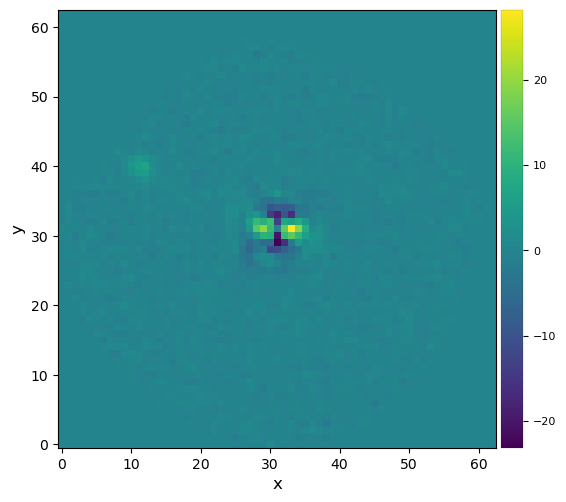

In [13]:
# frame, cubes_out, cubes_der = res  # pca
# cubes_out, cubes_der, frame = res  # pca_annular, asdi
# frame, channels_out, channels_der = res # for double
# frame, channels_out, channels_der = res # for single
# frame = res # asdi_npy

# plot_frames(frame)
# plot_cubes(cubes_out, backend="bokeh")
# plot_cubes(cubes_der, backend="bokeh")
# plt.imshow(frame)
# plt.show()


In [55]:
cc_kwargs = {"psf_template": psfn, "algo": algo, "pxscale": pxscale, "starphot": starphot,
             "sigma": 5, "nbranch": nbranch, "theta": theta, "inner_rad": inner_rad,
             "fc_rad_sep": fc_rad_sep, "noise_sep": noise_sep, "student": student,
             "smooth": smooth, "interp_order": interp_order, "debug": debug,
             "plot": plot, **rot_options, **algo_dict, **args_req}

In [ ]:
cc_res = contrast_curve(**cc_kwargs)